<a href="https://colab.research.google.com/github/componavt/LLLE-R1900s/blob/main/src/visualization/heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Grouped Bar Chart: Annual Loan Volumes & Counts by Credit Type

Visualizes **annual dynamics** of selected credit categories across all settlements.

**Top bars (↑)** = total loan amount (in **thousands of rubles**)  
**Bottom bars (↓)** = total number of loans  

Each selected credit type is shown with:
- **Unique color**
- **Consistent style** for both amount and count (same color for ↑ and ↓)

✨ **Features:**
- 🌍 Fully bilingual: toggle between Russian (`ru`) and English (`en`)
- 📅 X-axis = years (e.g., 1913–1917)
- 🎨 Configurable credit types via `SELECTED_CREDIT_ITEMS`
- 📈 Dual-axis: positive (amount) and negative (count) bars share color per category
- 🖼️ Rendered directly in Google Colab

⚙️ Configure via:
- `USE_LANGUAGE` — `"ru"` or `"en"`
- `SELECTED_CREDIT_ITEMS` — list of `Name` values from `credit_items.csv`

⚙️ [2] Install Dependencies & Set Language + Credit Selection

In [7]:
# Install dependencies for data processing and static plotting
!apt-get update -qq
!apt-get install -yqq libxcb-cursor0 libxcb-shm0 libxcb-xfixes0 libxcb-render0 libxcb-randr0 libxcb-glx0 libxkbcommon0

# We do NOT install kaleido or plotly>=6.1.1 since we'll use matplotlib for static output
!pip install -q python-dotenv pandas plotly matplotlib

# Clone the repo if running in Colab (optional — if data not uploaded manually)
import os

if not os.path.exists('LLLE-R1900s'):
    !git clone https://github.com/componavt/LLLE-R1900s.git
    %cd LLLE-R1900s
else:
    %cd LLLE-R1900s

# === LANGUAGE SWITCH ===
USE_LANGUAGE = "ru"
assert USE_LANGUAGE in ("ru", "en"), "USE_LANGUAGE must be 'ru' or 'en'"

# === SELECT CREDIT TYPES TO VISUALIZE ===
SELECTED_CREDIT_ITEMS = ["Migration", "CraftMaterials", "CraftTools"]

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Cloning into 'LLLE-R1900s'...
remote: Enumerating objects: 703, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 703 (delta 76), reused 13 (delta 5), pack-reused 583 (from 1)
Receiving objects: 100% (703/703), 9.21 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (513/513), done.
/content/LLLE-R1900s/LLLE-R1900s


📥 [3] Load & Prepare Data

In [8]:
import os
import pandas as pd
from dotenv import load_dotenv

# Validate SELECTED_CREDIT_ITEMS early (now that pandas is available)
valid_names = set(pd.read_csv('data/credit_items.csv')['Name'])
invalid = set(SELECTED_CREDIT_ITEMS) - valid_names
if invalid:
    raise ValueError(f"Invalid credit item(s): {invalid}. Must be from 'Name' column in credit_items.csv.")

# Load configuration
load_dotenv('config.env')

# Paths
csv_out_dir = os.getenv('CSV_OUT_DIR', 'data/csv_out')
output_file_name = os.getenv('OUTPUT_CSV_FILE')

if not output_file_name:
    csv_files = [f for f in os.listdir(csv_out_dir) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the output directory.")
    output_file_name = csv_files[0]

csv_path = os.path.join(csv_out_dir, output_file_name)
print(f"Loading loan data from: {csv_path}")

# Load main loan data
df_loans = pd.read_csv(csv_path)
print(f"Loaded {len(df_loans)} loan records.")

# Load credit items
df_credit = pd.read_csv('data/credit_items.csv')
print(f"Loaded {len(df_credit)} credit item definitions.")

# --- Build credit item display label map ---
if USE_LANGUAGE == "ru":
    df_credit['display_label'] = df_credit['loan_short_ru']
else:
    df_credit['display_label'] = df_credit['Name']

label_map = dict(zip(df_credit['Name'], df_credit['display_label']))

# Filter loans to only selected credit items
df_loans = df_loans[df_loans['credit_item'].isin(SELECTED_CREDIT_ITEMS)].copy()

# Ensure numeric types
df_loans['amount_rubles'] = pd.to_numeric(df_loans['amount_rubles'], errors='coerce').fillna(0)
df_loans['loan_count'] = pd.to_numeric(df_loans['loan_count'], errors='coerce').fillna(0).astype(int)

print(f"Filtered to {len(df_loans)} records for selected credit types: {SELECTED_CREDIT_ITEMS}")

Loading loan data from: data/csv_out/loans_s28_i21.csv
Loaded 1768 loan records.
Loaded 21 credit item definitions.
Filtered to 264 records for selected credit types: ['Migration', 'CraftMaterials', 'CraftTools']


🔍 [4] Calculate Axis Extents and Prepare Annotations

In [9]:
# Aggregate by year and credit_item
df_annual = df_loans.groupby(['year', 'credit_item']).agg(
    total_amount=('amount_rubles', 'sum'),
    total_count=('loan_count', 'sum')
).reset_index()

df_annual['total_amount_k'] = df_annual['total_amount'] / 1000.0

years = sorted(df_annual['year'].unique())
credit_items = SELECTED_CREDIT_ITEMS

max_amount = df_annual['total_amount_k'].max() if not df_annual.empty else 1
max_count = df_annual['total_count'].max() if not df_annual.empty else 1

print(f"📈 Max loan amount (thsd rub): {max_amount:.2f}")
print(f"📊 Max loan count: {max_count}")

# --- Normalize both series to [-1, 1] range for visual balance ---
# We'll map [0, max_amount] → [0, 1] and [0, max_count] → [0, -1]
amount_norm = {}
count_norm = {}
amount_annotations = {}
count_annotations = {}

CREDIT_SYMBOLS = {
    "Migration": "🚶",
    "CraftMaterials": "🧵",
    "CraftTools": "🔨"
}

for item in credit_items:
    subset = df_annual[df_annual['credit_item'] == item]
    amount_dict = dict(zip(subset['year'], subset['total_amount_k']))
    count_dict = dict(zip(subset['year'], subset['total_count']))

    raw_amounts = [amount_dict.get(y, 0) for y in years]
    raw_counts = [count_dict.get(y, 0) for y in years]

    # Normalize
    norm_amounts = [a / max_amount if max_amount > 0 else 0 for a in raw_amounts]
    norm_counts = [-c / max_count if max_count > 0 else 0 for c in raw_counts]  # negative direction

    amount_norm[item] = norm_amounts
    count_norm[item] = norm_counts

    # Annotations show REAL values (not normalized)
    amount_annotations[item] = [f"{a:.1f}" if a > 0 else "" for a in raw_amounts]
    count_annotations[item] = [
        f"{CREDIT_SYMBOLS.get(item, '')}\n{int(c)}" if c > 0 else ""
        for c in raw_counts
    ]

# Store for cell 5
PLOT_DATA = {
    'years': years,
    'credit_items': credit_items,
    'amount_norm': amount_norm,
    'count_norm': count_norm,
    'amount_annotations': amount_annotations,
    'count_annotations': count_annotations,
    'max_amount': max_amount,
    'max_count': max_count
}

📈 Max loan amount (thsd rub): 9.56
📊 Max loan count: 249


[5] 🛠️ Helper Functions for Network and Similarity Analysis

🔥 create_similarity_heatmap()
*   Creates a clustered heatmap with dendrograms showing similarity between societies.

*   🎨 Uses customizable color maps (viridis_r by default)
*   🌐 Fully bilingual: automatically switches labels based on USE_LANGUAGE
*   📏 Enhanced readability: Society names displayed in large font (size 22)
*   📊 Includes colorbar with proper labeling
*   🔄 Falls back to simple

In [14]:
# ================================
# HELPER FUNCTIONS (ADAPTED FOR EXISTING DATA)
# ================================

def create_similarity_heatmap(sim_matrix, title, cmap='viridis_r', center=None,
                             cbar_label='Similarity', figsize=(16, 14), output_dir=None, filename=None):
    """
    Create clustered heatmap with dendrograms using existing data

    Parameters:
    sim_matrix : pd.DataFrame
        Similarity matrix (societies x societies)
    title : str
        Plot title
    cmap : str
        Colormap name
    center : float or None
        Center value for diverging colormaps
    cbar_label : str
        Colorbar label
    figsize : tuple
        Figure size
    output_dir : str
        Output directory for saving
    filename : str
        Filename for saving

    Returns:
    plt.Figure
    """
    societies = sim_matrix.index.tolist()

    # Only cluster if we have enough societies and data is valid
    if len(societies) > 2 and not sim_matrix.isnull().values.any():
        try:
            # Calculate linkage with compatible method
            row_linkage = linkage(sim_matrix, method='average', metric='euclidean')
            col_linkage = linkage(sim_matrix.T, method='average', metric='euclidean')

            # Create clustered heatmap
            g = sns.clustermap(
                sim_matrix,
                cmap=cmap,
                center=center,
                row_linkage=row_linkage,
                col_linkage=col_linkage,
                figsize=figsize,
                annot=False,
                cbar_pos=(0.02, 0.85, 0.03, 0.12),
                cbar_kws={'label': cbar_label},
                linewidths=0.5,
                linecolor='lightgray',
                dendrogram_ratio=0.1,
                tree_kws={'linewidths': 1.5}
            )

            # Add axis labels with proper language
            if USE_LANGUAGE == "en":
                g.ax_heatmap.set_xlabel('Society', fontsize=16)
                g.ax_heatmap.set_ylabel('Society', fontsize=16)
                plt.suptitle(title, fontsize=16, y=0.92, x=0.5)
            else:
                g.ax_heatmap.set_xlabel('Товарищество', fontsize=16)
                g.ax_heatmap.set_ylabel('Товарищество', fontsize=16)
                plt.suptitle(title, fontsize=16, y=0.92, x=0.5)

            # Rotate x-axis labels for readability with larger font size
            plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=16)
            plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=16)

            fig = g.fig

        except Exception as e:
            print(f"⚠️ Clustering not possible: {e}. Using simple heatmap.")
            fig = simple_heatmap(sim_matrix, title, cmap, center, cbar_label, figsize)
    else:
        print("ℹ️ Not enough data for clustering. Using simple heatmap.")
        fig = simple_heatmap(sim_matrix, title, cmap, center, cbar_label, figsize)

    # Save if needed
    if output_dir and filename:
        os.makedirs(output_dir, exist_ok=True)
        filepath = os.path.join(output_dir, filename)
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {filepath}")

    return fig

def simple_heatmap(sim_matrix, title, cmap='viridis_r', center=None,
                  cbar_label='Similarity', figsize=(14, 12)):
    """Fallback heatmap without clustering"""
    fig, ax = plt.subplots(figsize=figsize)

    if center is not None:
        sns.heatmap(sim_matrix, cmap=cmap, center=center, square=True, ax=ax,
                   cbar_kws={'label': cbar_label}, linewidths=0.5, linecolor='lightgray')
    else:
        sns.heatmap(sim_matrix, cmap=cmap, square=True, ax=ax,
                   cbar_kws={'label': cbar_label}, linewidths=0.5, linecolor='lightgray')

    # Set labels with proper language and larger font sizes
    if USE_LANGUAGE == "en":
        ax.set_title(title, fontsize=16, pad=20)
        ax.set_xlabel('Society', fontsize=14)
        ax.set_ylabel('Society', fontsize=14)
    else:
        ax.set_title(title, fontsize=16, pad=20)
        ax.set_xlabel('Товарищество', fontsize=14)
        ax.set_ylabel('Товарищество', fontsize=14)

    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    return fig

def create_similarity_network(sim_matrix, threshold, title, edge_color_map='viridis',
                             node_color='lightblue', figsize=(16, 14), output_dir=None, filename=None,
                             layout_type='spring', k=1.0, iterations=200):
    """
    Create network graph from similarity matrix using existing data

    Parameters:
    sim_matrix : pd.DataFrame
        Similarity matrix (societies x societies)
    threshold : float
        Minimum similarity to create edge
    title : str
        Plot title
    edge_color_map : str or callable
        Colormap for edges or custom function
    node_color : str
        Base node color
    figsize : tuple
        Figure size
    output_dir : str
        Output directory for saving
    filename : str
        Filename for saving
    layout_type : str
        Type of layout: 'spring', 'kamada_kawai', 'spectral'
    k : float
        Optimal distance between nodes for spring layout
    iterations : int
        Number of iterations for layout algorithm

    Returns:
    plt.Figure or None if no edges
    """
    societies = sim_matrix.index.tolist()

    # Create graph
    G = nx.Graph()
    G.add_nodes_from(societies)

    # Add edges with weights = similarity
    for i, soc1 in enumerate(societies):
        for j, soc2 in enumerate(societies):
            if j <= i: continue
            sim = sim_matrix.loc[soc1, soc2]
            if sim > threshold:
                G.add_edge(soc1, soc2, weight=sim, similarity=round(sim, 3))

    # Skip if no edges
    if G.number_of_edges() == 0:
        print(f"⚠️ No connections above threshold {threshold}. Graph will not be created.")
        return None

    # Create layout with different options to prevent node clustering
    if layout_type == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G, weight='weight')
    elif layout_type == 'spectral':
        pos = nx.spectral_layout(G)
    else:  # spring layout with custom parameters
        pos = nx.spring_layout(G, weight='weight', k=k, iterations=iterations, seed=42)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Get edges and their weights
    edges = G.edges(data=True)
    weights = [d['weight'] for _, _, d in edges]
    max_weight = max(weights) if weights else 1

    # Draw edges with thickness and color based on similarity
    for (u, v, d), w in zip(edges, weights):
        edge_width = w * 5  # Scale for visibility

        if callable(edge_color_map):
            edge_color = edge_color_map(w)
        else:
            edge_color = plt.cm.get_cmap(edge_color_map)(w)

        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_width,
                              edge_color=[edge_color], alpha=0.8)

    # Draw nodes with size based on degree
    node_degrees = dict(G.degree())
    max_degree = max(node_degrees.values()) if node_degrees else 1
    node_sizes = [node_degrees.get(node, 0) * 80 + 150 for node in G.nodes()]  # Base size + degree scaling

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_color,
                          alpha=0.9, edgecolors='black')

    # Draw labels with offset to avoid overlap and ensure readability
    label_offsets = {}
    for node, (x, y) in pos.items():
        # Calculate offset based on position to avoid overlap
        if abs(x) < 0.3 and abs(y) < 0.3:
            offset_x, offset_y = 0.1, 0.1
        elif x > 0:
            offset_x, offset_y = 0.08, 0
        else:
            offset_x, offset_y = -0.08, 0

        label_offsets[node] = (x + offset_x, y + offset_y)

    # Increased font size for node labels
    nx.draw_networkx_labels(G, label_offsets, labels={node: node for node in G.nodes()},
                           font_size=16, font_weight='bold')

    plt.title(title, fontsize=18, pad=20)
    plt.axis('off')
    plt.tight_layout()

    # Save if needed
    if output_dir and filename and G.number_of_edges() > 0:
        os.makedirs(output_dir, exist_ok=True)
        filepath = os.path.join(output_dir, filename)
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {filepath}")

    return fig

🌡️ [6] Heat Maps: Similarity Between Societies by Loan Patterns

🔍 Analyzing 22 societies with selected credit types: Migration, CraftMaterials, CraftTools
📋 Societies to analyze (22): Gimoretskoye, Ivinskoye, Kondopoga, Korbozero, Kotkozero...


📊 ТИП 1: СХОДСТВО В СТРУКТУРЕ КРЕДИТНЫХ ПОРТФЕЛЕЙ
Кластеризованная тепловая карта показывает косинусное сходство долей разных типов ссуд в кредитных портфелях. 
Более тёмные цвета и близкое расположение в дендрограмме указывают на более похожие структуры кредитования. 
Кластеры в правом нижнем углу указывают на группы товариществ со схожей экономической специализацией.
✅ Saved: figures/network_analysis/heatmap_structure_similarity_clustered.png


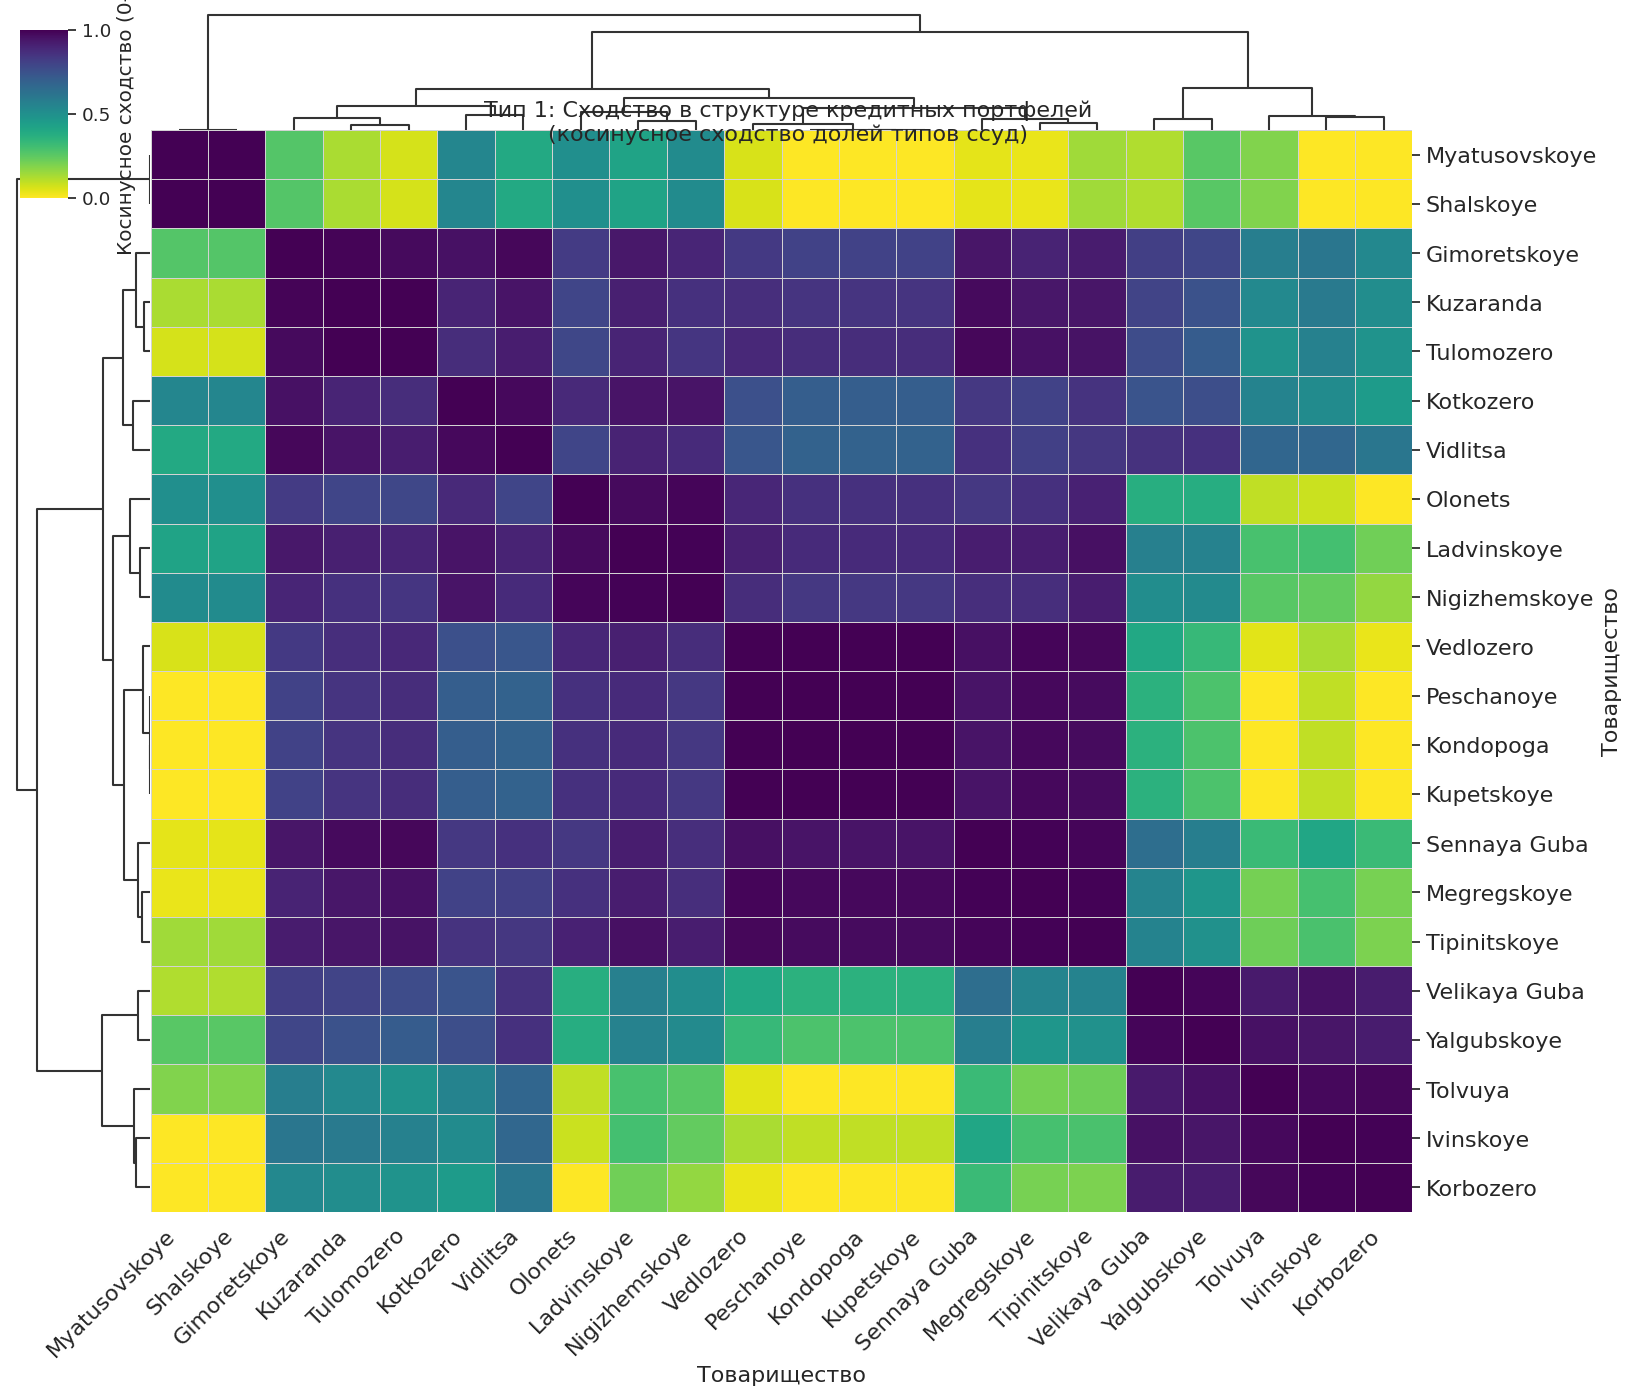


🌐 ГРАФ СХОДСТВА СТРУКТУРЫ КРЕДИТНЫХ ПОРТФЕЛЕЙ
На этом графе расстояние между товариществами обратно пропорционально сходству в структуре кредитования. 
Плотные кластеры (например, в правом верхнем углу) указывают на группы с похожей экономической специализацией. 
Размер узлов отражает количество связей — чем больше размер, тем более 'центральное' положение в сети.
✅ Saved: figures/network_analysis/network_structure_similarity.png


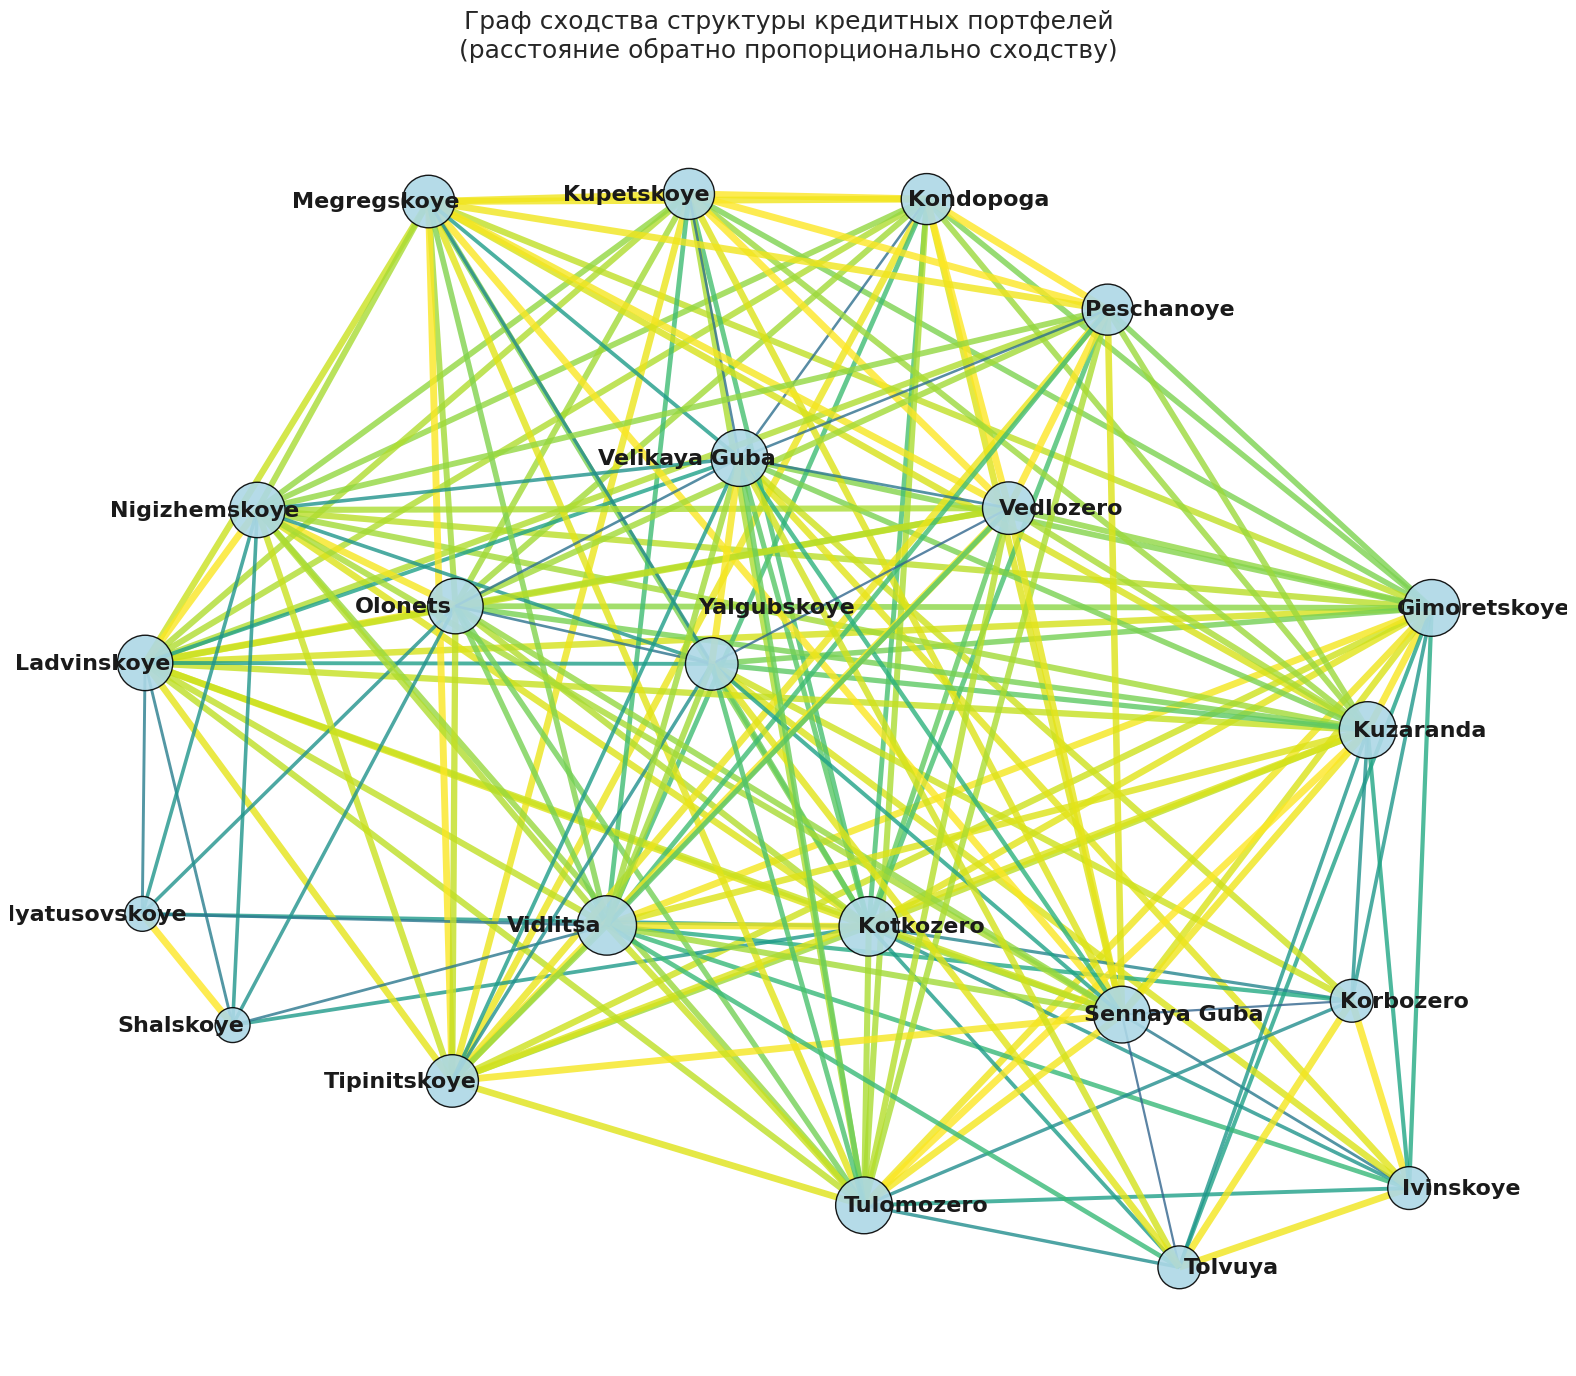



📈 ТИП 2: СХОДСТВО В ДИНАМИКЕ ОБЩЕГО ОБЪЁМА ССУД
Кластеризованная тепловая карта показывает корреляцию Пирсона между нормализованными временными рядами общего объёма ссуд. 
Тёмно-красные кластеры (корреляция ≈ 1) — товарищества с очень похожей динамикой, 
тёмно-синие области (корреляция ≈ -1) — с противоположной динамикой. 
Дендрограммы группируют товарищества по сходству реакции на экономические события.
✅ Saved: figures/network_analysis/heatmap_dynamics_similarity_clustered.png


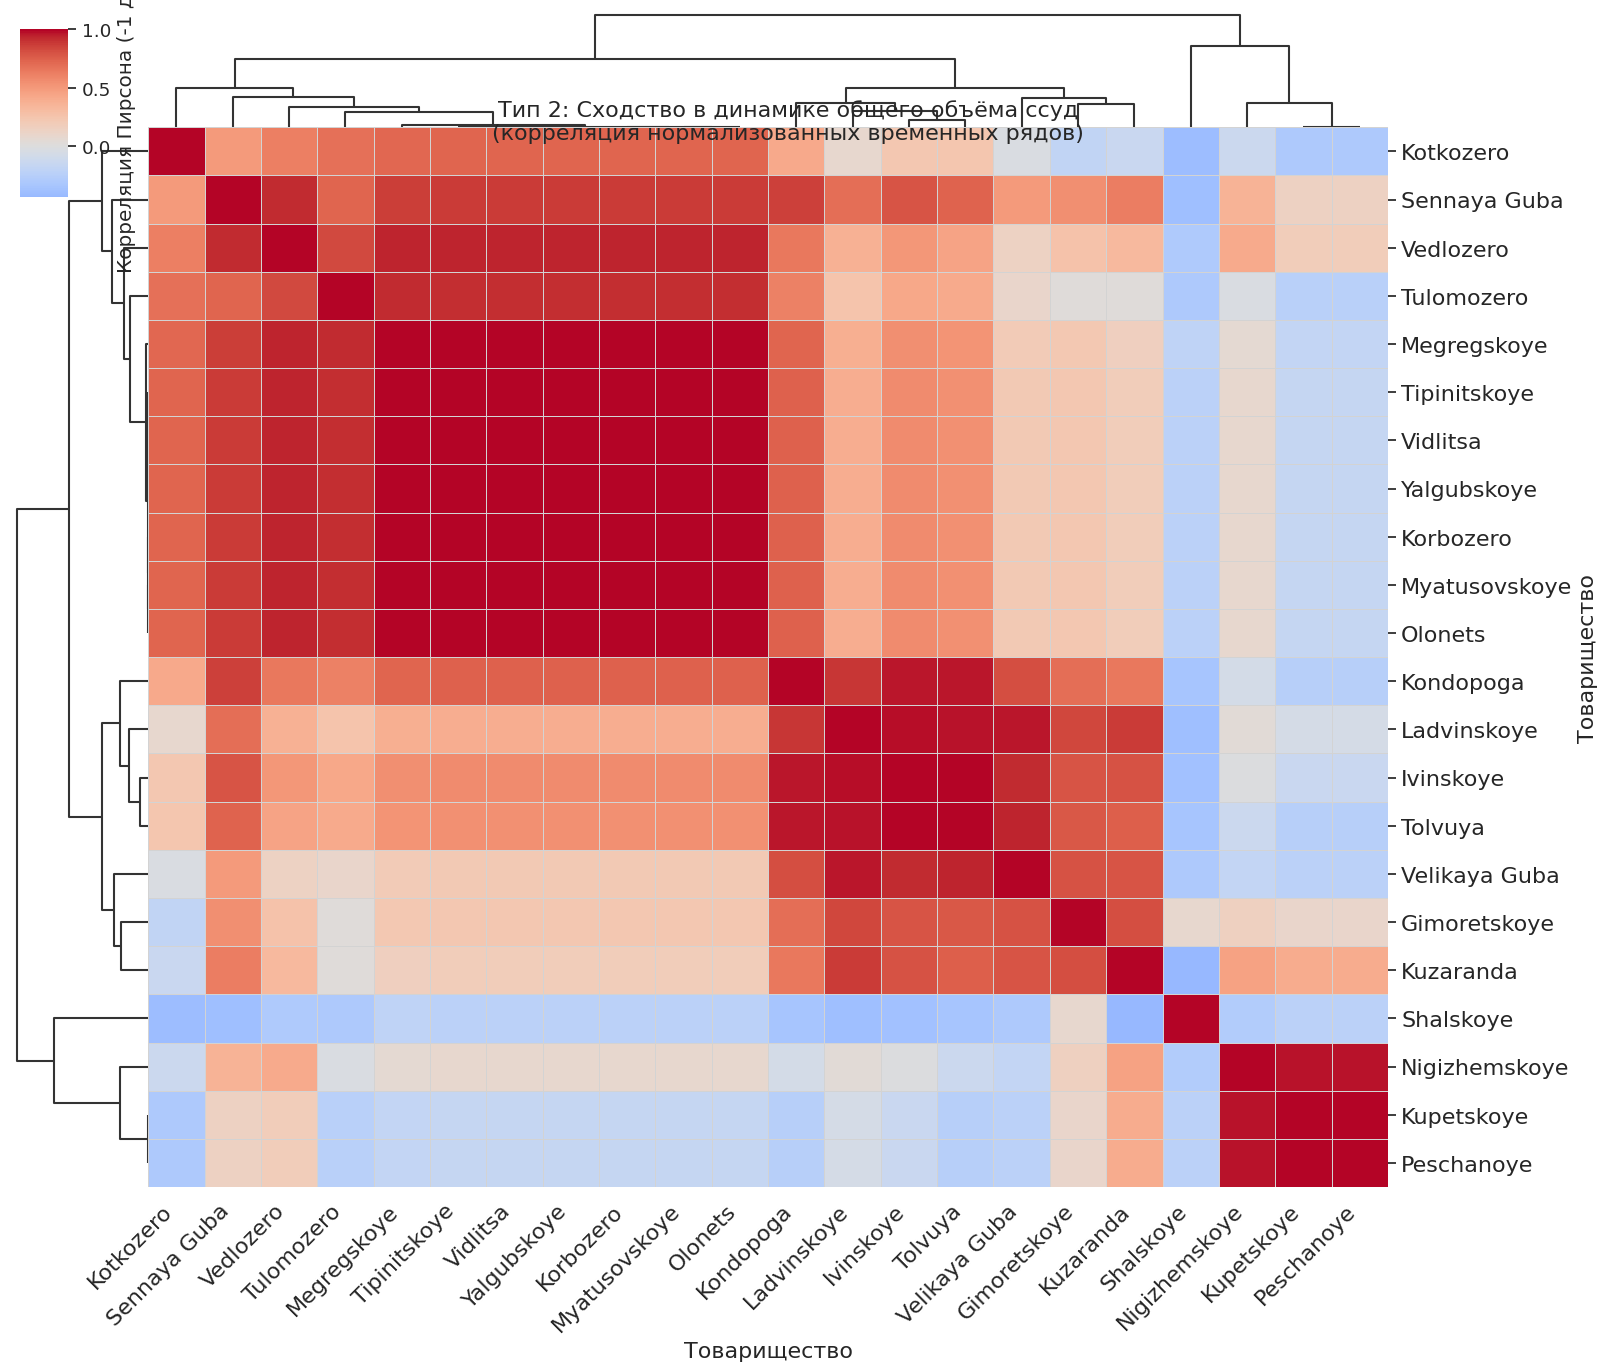


🌐 ГРАФ СХОДСТВА ДИНАМИКИ ОБЩЕГО ОБЪЁМА ССУД
На этом графе расстояние между товариществами обратно пропорционально корреляции их динамики. 
Красные рёбра — положительная корреляция (похожие тренды), синие рёбра — отрицательная корреляция (противоположные тренды). 
Кластеры могут отражать общие внешние факторы: географическую близость, доступ к рынкам или инфраструктуру.
✅ Saved: figures/network_analysis/network_dynamics_similarity.png


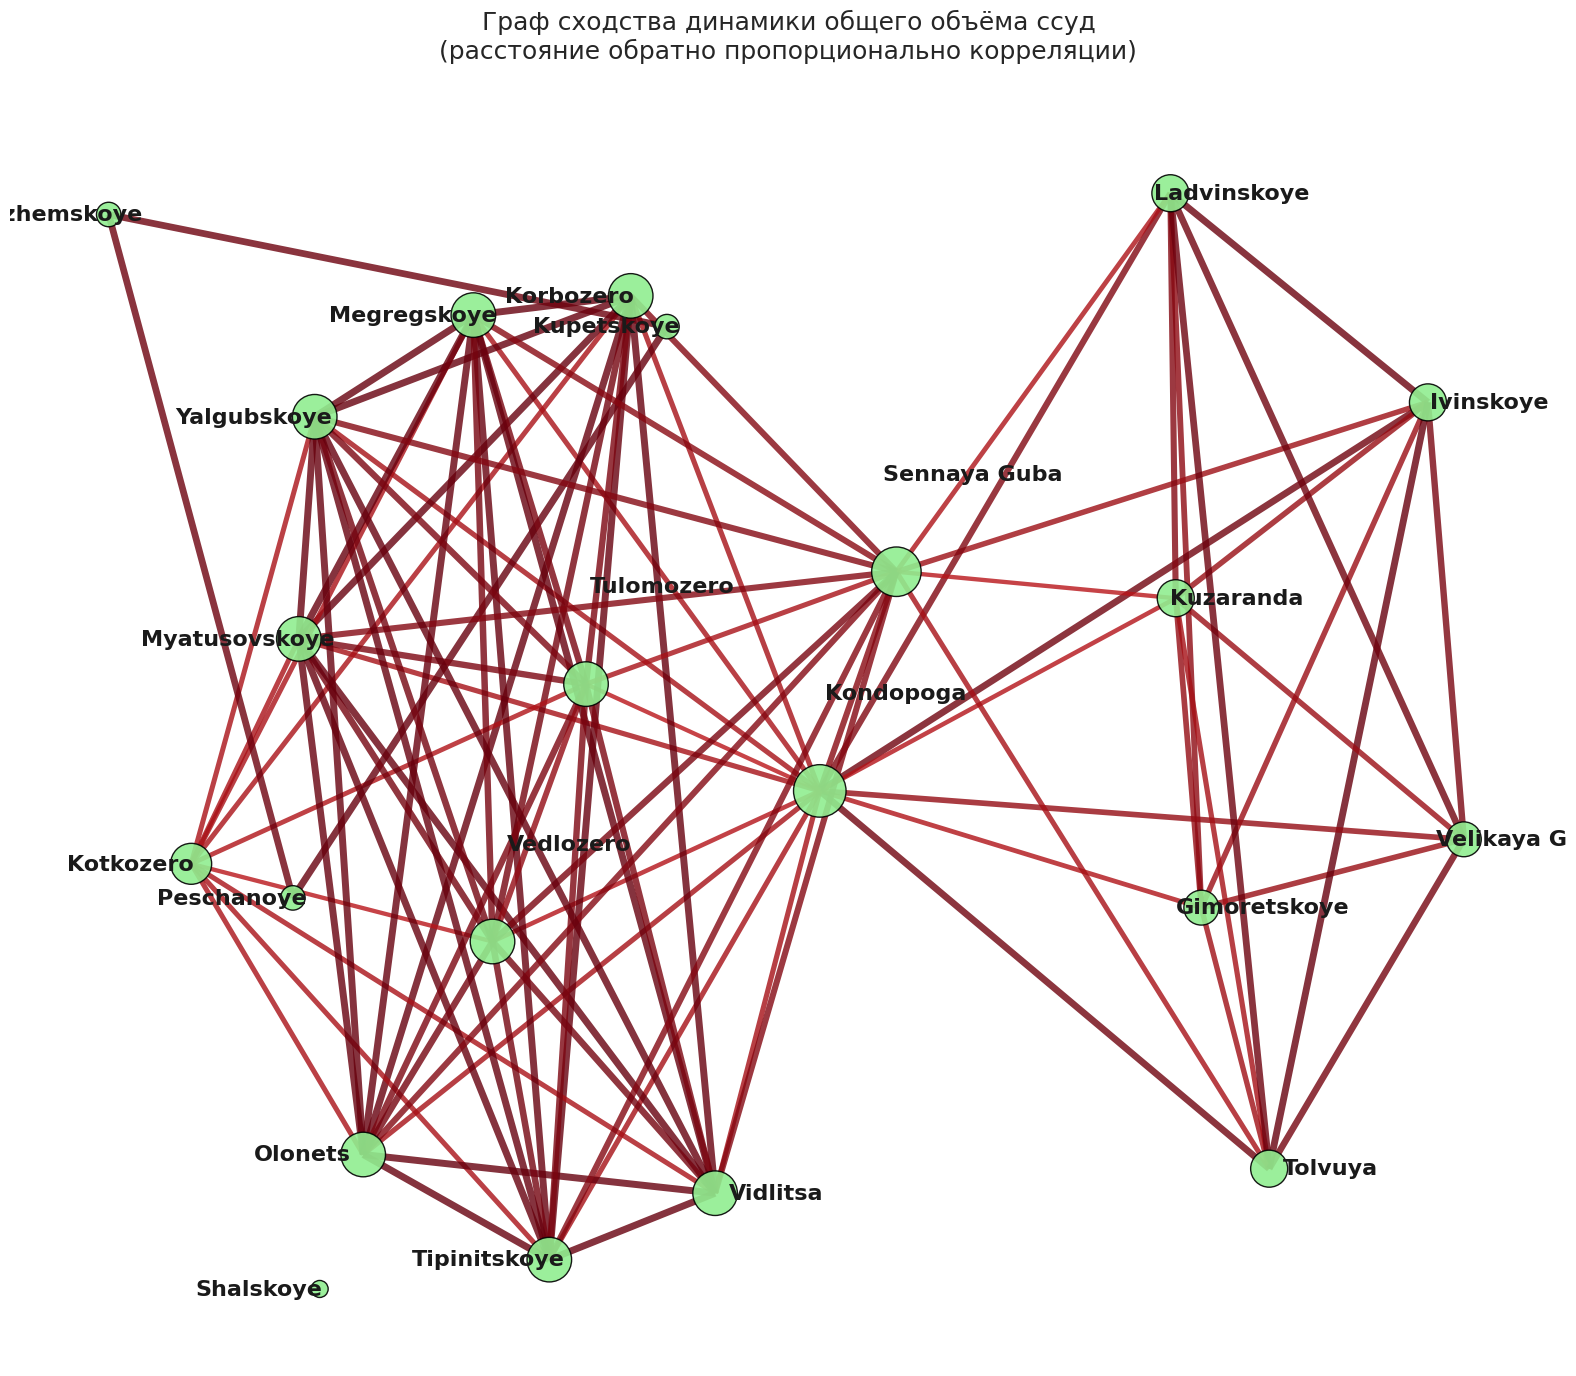



🎯 ТИП 3: ОБЩЕЕ СХОДСТВО МЕЖДУ ТОВАРИЩЕСТВАМИ ПО ВСЕМ ТИПАМ ССУД
Этот анализ рассчитывает комплексное сходство между товариществами на основе их полных паттернов кредитования.
Тепловая карта показывает косинусное сходство по всем доступным типам ссуд (не только выбранным).
Это даёт целостное представление о том, какие товарищества имели схожие паттерны кредитования в целом.
🔄 Загрузка полных данных по ссудам из: data/csv_out/loans_s28_i21.csv (не отфильтрованные по типам кредитов)
✅ Загружено 1768 записей о ссудах из полного набора данных
📊 Найдено 19 товариществ с данными за 2+ года для комплексного анализа
✅ Saved: figures/network_analysis/heatmap_overall_similarity_clustered.png


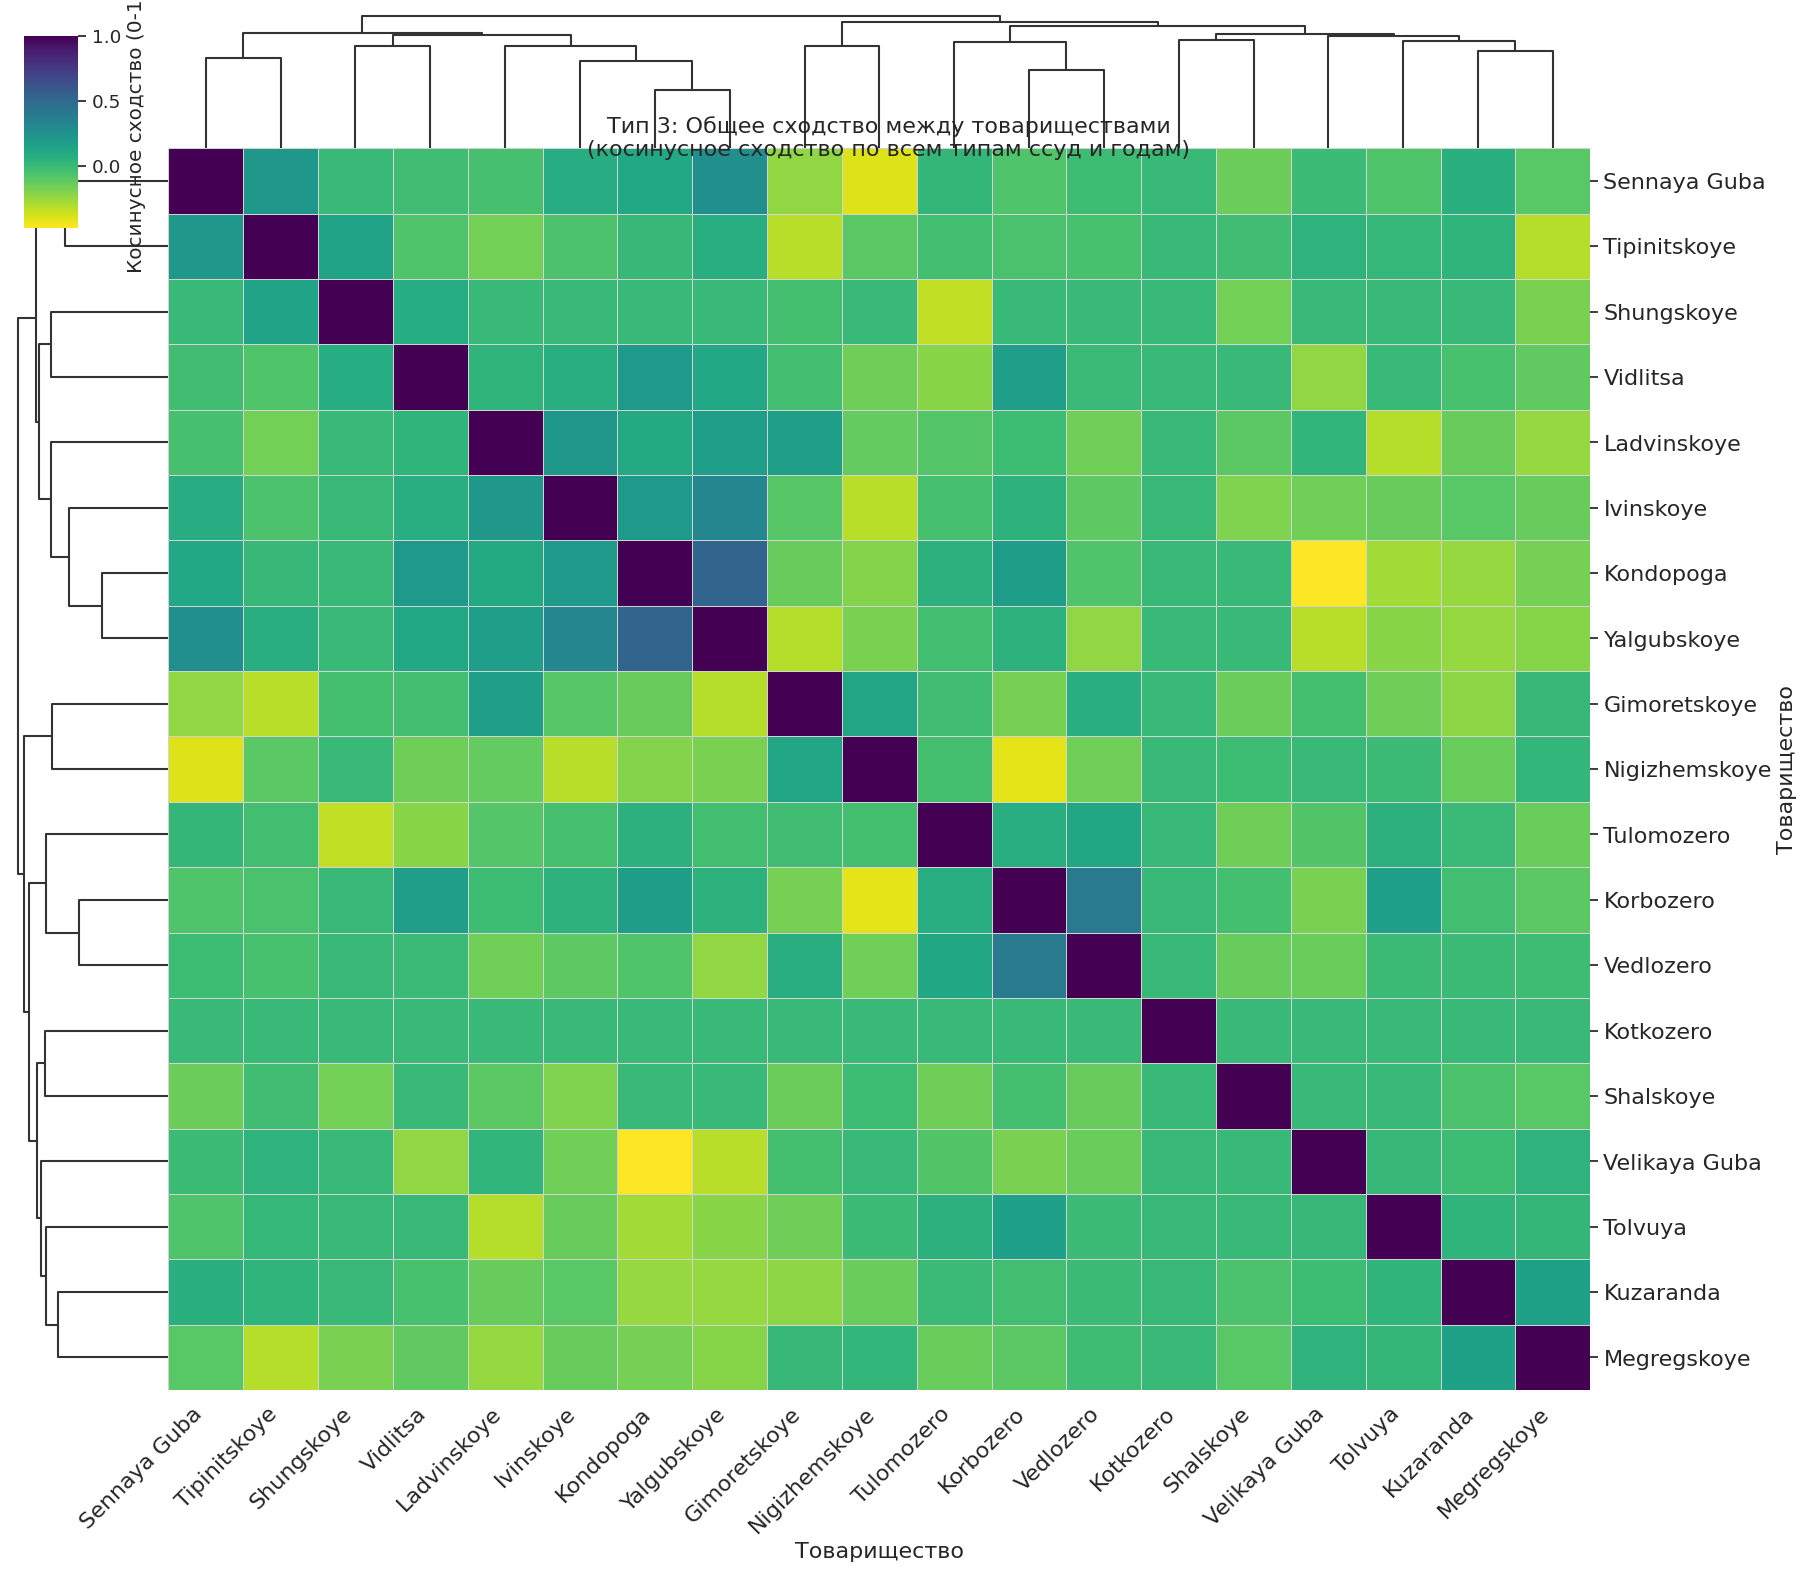


🌐 ГРАФ ОБЩЕГО СХОДСТВА МЕЖДУ ТОВАРИЩЕСТВАМИ
Этот граф показывает комплексное сходство между товариществами по всем типам ссуд и годам. Товарищества со схожими паттернами кредитования по всем категориям расположены ближе друг к другу. Размер узлов отражает количество сильных связей (сходство > 0.4) - более крупные узлы занимают центральное положение в сети.
✅ Saved: figures/network_analysis/network_overall_similarity.png


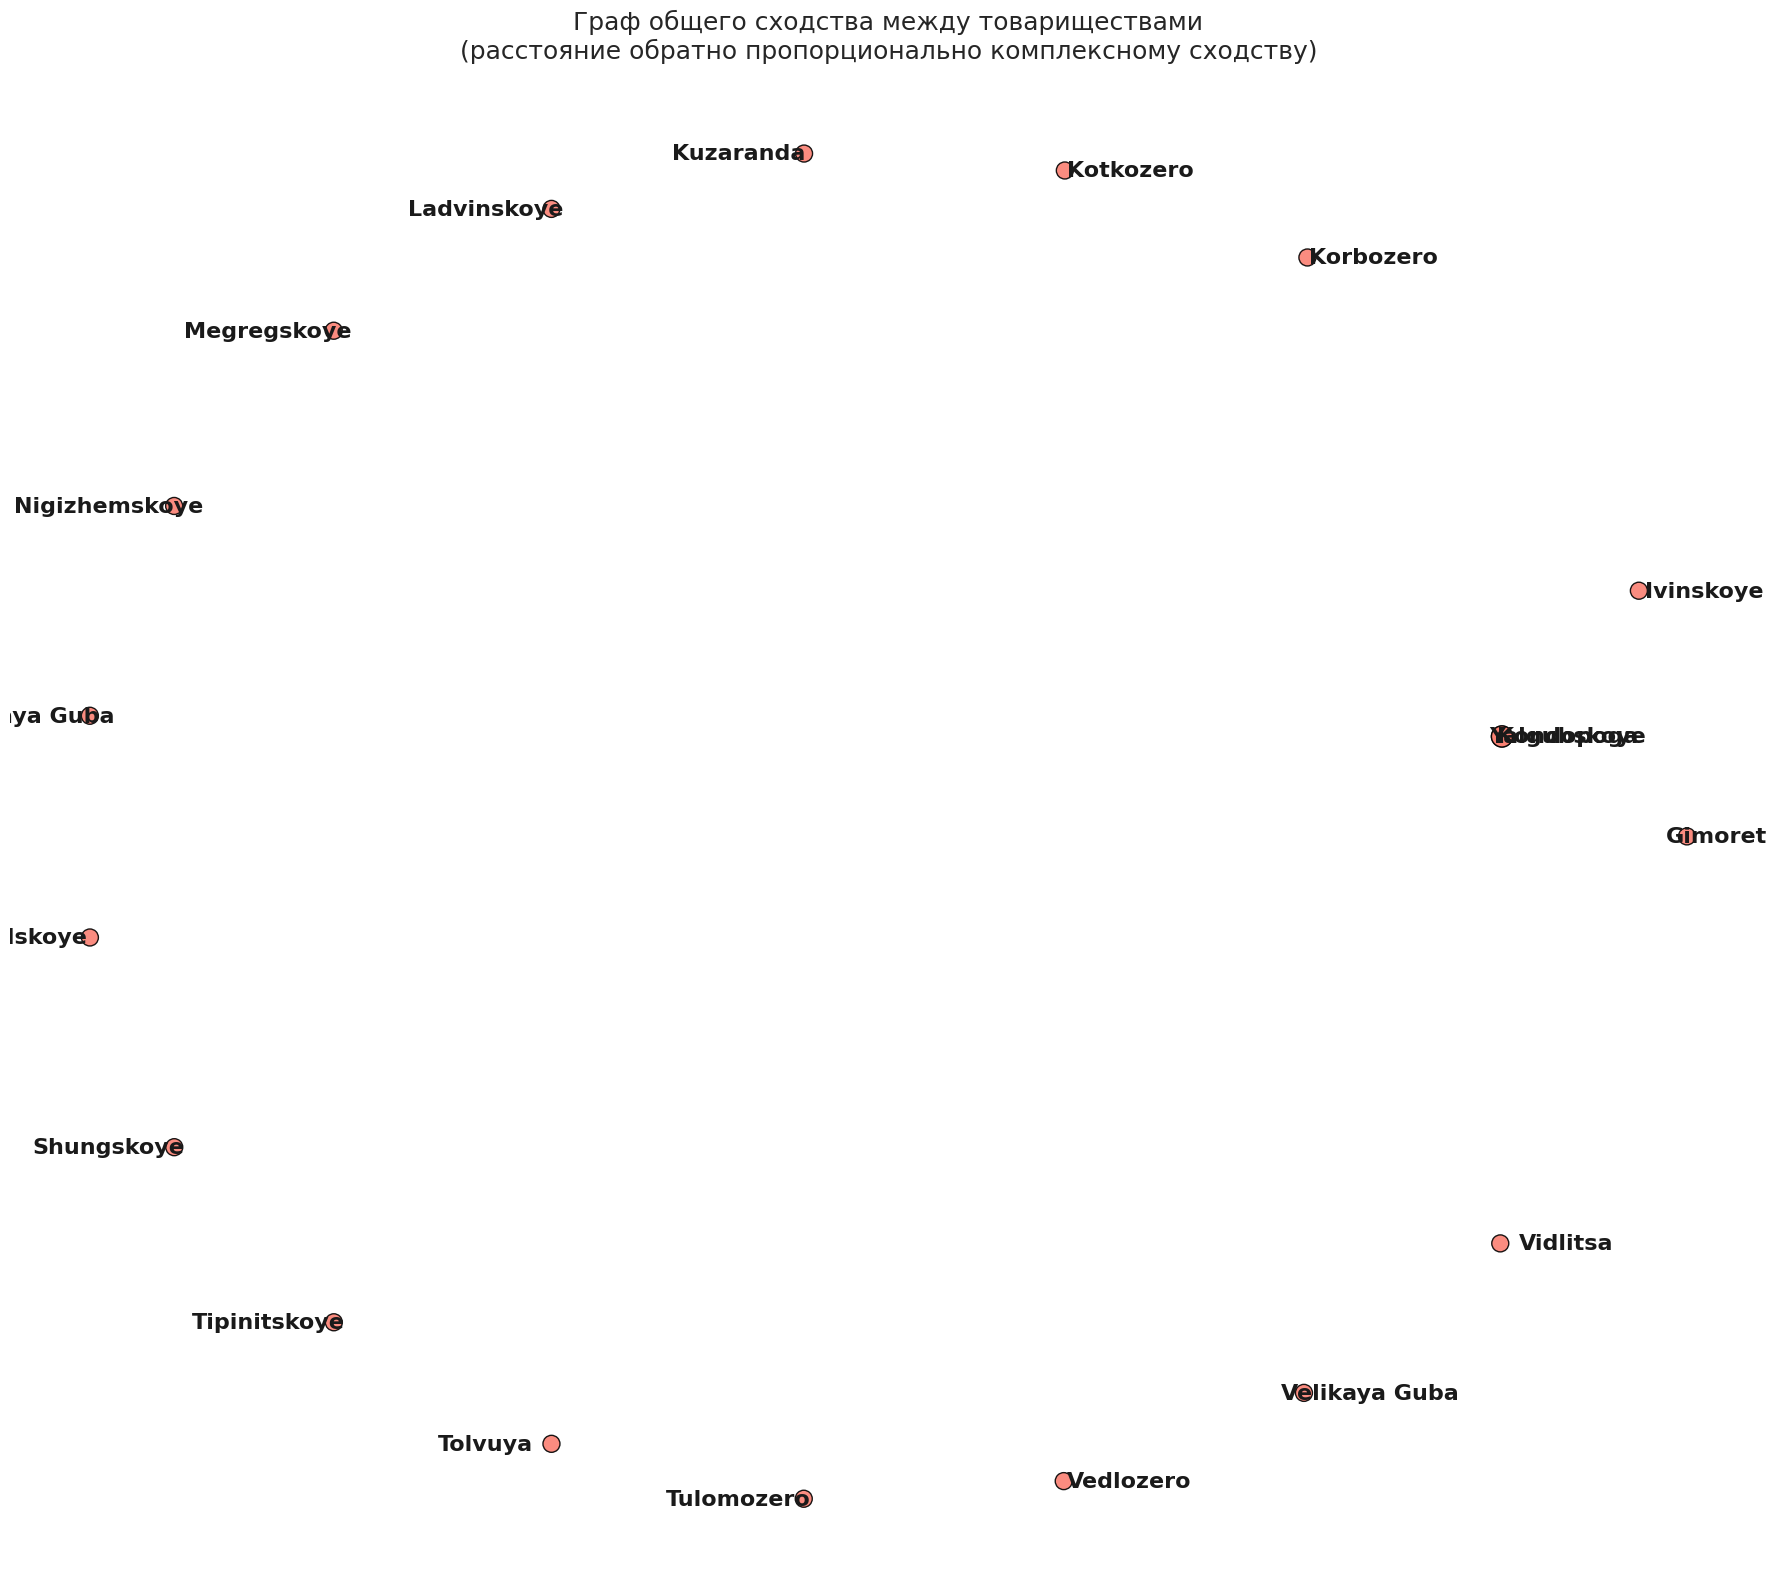



✨ АНАЛИЗ ЗАВЕРШЁН!
📁 Все визуализации сохранены в папку: figures/network_analysis


In [15]:
# 🌡️ [6] Heat Maps: Similarity Between Societies by Loan Patterns

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage
import os
import warnings
warnings.filterwarnings('ignore')

# ================================
# MAIN ANALYSIS USING EXISTING DATA
# ================================

# Use already loaded data from previous cells
print(f"🔍 Analyzing {df_loans['settlement'].nunique()} societies with selected credit types: {', '.join(SELECTED_CREDIT_ITEMS)}")

# Create output directory
output_dir = "figures/network_analysis"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)  # Increased font scale for better readability

# Get unique societies from filtered data
societies = sorted(df_loans['settlement'].unique())
print(f"📋 Societies to analyze ({len(societies)}): {', '.join(societies[:5])}...")

# ================================
# TYPE 1: SIMILARITY IN LOAN STRUCTURE
# ================================
if USE_LANGUAGE == "en":
    print("\n\n📊 TYPE 1: SIMILARITY IN LOAN PORTFOLIO STRUCTURE")
    print("Clustered heatmap shows cosine similarity of loan type proportions in credit portfolios. ")
    print("Darker colors and closer placement in dendrogram indicate more similar lending structures. ")
    print("Clusters in the bottom-right corner indicate groups of societies with similar economic specialization.")
else:
    print("\n\n📊 ТИП 1: СХОДСТВО В СТРУКТУРЕ КРЕДИТНЫХ ПОРТФЕЛЕЙ")
    print("Кластеризованная тепловая карта показывает косинусное сходство долей разных типов ссуд в кредитных портфелях. ")
    print("Более тёмные цвета и близкое расположение в дендрограмме указывают на более похожие структуры кредитования. ")
    print("Кластеры в правом нижнем углу указывают на группы товариществ со схожей экономической специализацией.")

# Build structure matrix using existing filtered data
structure_df = df_loans.pivot_table(
    index='settlement',
    columns='credit_item',
    values='amount_rubles',
    aggfunc='sum',
    fill_value=0
)
structure_prop = structure_df.div(structure_df.sum(axis=1), axis=0).fillna(0)
sim_structure = pd.DataFrame(cosine_similarity(structure_prop),
                            index=societies, columns=societies)

# Plot clustered heatmap with proper language
if USE_LANGUAGE == "en":
    title1 = 'Type 1: Similarity in Credit Portfolio Structure\n(cosine similarity of loan type proportions)'
    cbar_label1 = 'Cosine Similarity (0-1)'
else:
    title1 = 'Тип 1: Сходство в структуре кредитных портфелей\n(косинусное сходство долей типов ссуд)'
    cbar_label1 = 'Косинусное сходство (0-1)'

fig1 = create_similarity_heatmap(
    sim_structure,
    title=title1,
    cmap='viridis_r',
    cbar_label=cbar_label1,
    figsize=(16, 14),
    output_dir=output_dir,
    filename='heatmap_structure_similarity_clustered.png'
)
plt.show()

# Build and plot network graph
if USE_LANGUAGE == "en":
    print("\n🌐 NETWORK GRAPH: SIMILARITY IN LOAN PORTFOLIO STRUCTURE")
    print("In this graph, distance between societies is inversely proportional to structural similarity. ")
    print("Dense clusters (e.g., in top-right corner) indicate groups with similar economic specialization. ")
    print("Node size reflects number of connections - larger nodes have more 'central' position in the network.")
else:
    print("\n🌐 ГРАФ СХОДСТВА СТРУКТУРЫ КРЕДИТНЫХ ПОРТФЕЛЕЙ")
    print("На этом графе расстояние между товариществами обратно пропорционально сходству в структуре кредитования. ")
    print("Плотные кластеры (например, в правом верхнем углу) указывают на группы с похожей экономической специализацией. ")
    print("Размер узлов отражает количество связей — чем больше размер, тем более 'центральное' положение в сети.")

# Custom edge color function for structure graph
def structure_edge_color(sim):
    return plt.cm.viridis(sim)

# Network graph title with proper language
if USE_LANGUAGE == "en":
    net_title1 = 'Network of Credit Portfolio Structure Similarity\n(distance inversely proportional to similarity)'
else:
    net_title1 = 'Граф сходства структуры кредитных портфелей\n(расстояние обратно пропорционально сходству)'

fig1_net = create_similarity_network(
    sim_structure,
    threshold=0.3,
    title=net_title1,
    edge_color_map=structure_edge_color,
    node_color='lightblue',
    figsize=(16, 14),
    output_dir=output_dir,
    filename='network_structure_similarity.png',
    layout_type='kamada_kawai'  # Better layout for readability
)
if fig1_net:
    plt.show()

# ================================
# TYPE 2: SIMILARITY IN AGGREGATE DYNAMICS
# ================================
if USE_LANGUAGE == "en":
    print("\n\n📈 TYPE 2: SIMILARITY IN OVERALL LOAN VOLUME DYNAMICS")
    print("Clustered heatmap shows Pearson correlation between normalized time series of total loan volumes. ")
    print("Dark red clusters (correlation ≈ 1) - societies with very similar dynamics, ")
    print("dark blue areas (correlation ≈ -1) - societies with opposite dynamics. ")
    print("Dendrograms group societies by similarity in response to economic events.")
else:
    print("\n\n📈 ТИП 2: СХОДСТВО В ДИНАМИКЕ ОБЩЕГО ОБЪЁМА ССУД")
    print("Кластеризованная тепловая карта показывает корреляцию Пирсона между нормализованными временными рядами общего объёма ссуд. ")
    print("Тёмно-красные кластеры (корреляция ≈ 1) — товарищества с очень похожей динамикой, ")
    print("тёмно-синие области (корреляция ≈ -1) — с противоположной динамикой. ")
    print("Дендрограммы группируют товарищества по сходству реакции на экономические события.")

# Build dynamics matrix using existing data
dynamics_df = df_loans.pivot_table(
    index='settlement',
    columns='year',
    values='amount_rubles',
    aggfunc='sum',
    fill_value=0
)
dynamics_norm = dynamics_df.apply(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else np.zeros_like(x),
    axis=1
).fillna(0)
sim_dynamics = dynamics_norm.T.corr()

# Plot clustered heatmap with proper language
if USE_LANGUAGE == "en":
    title2 = 'Type 2: Similarity in Total Loan Volume Dynamics\n(correlation of normalized time series)'
    cbar_label2 = 'Pearson Correlation (-1 to 1)'
else:
    title2 = 'Тип 2: Сходство в динамике общего объёма ссуд\n(корреляция нормализованных временных рядов)'
    cbar_label2 = 'Корреляция Пирсона (-1 до 1)'

fig2 = create_similarity_heatmap(
    sim_dynamics,
    title=title2,
    cmap='coolwarm',
    center=0,
    cbar_label=cbar_label2,
    figsize=(16, 14),
    output_dir=output_dir,
    filename='heatmap_dynamics_similarity_clustered.png'
)
plt.show()

# Build and plot network graph
if USE_LANGUAGE == "en":
    print("\n🌐 NETWORK GRAPH: SIMILARITY IN OVERALL LOAN VOLUME DYNAMICS")
    print("In this graph, distance between societies is inversely proportional to correlation of their dynamics. ")
    print("Red edges - positive correlation (similar trends), blue edges - negative correlation (opposite trends). ")
    print("Clusters may reflect common external factors: geographic proximity, market access, or infrastructure.")
else:
    print("\n🌐 ГРАФ СХОДСТВА ДИНАМИКИ ОБЩЕГО ОБЪЁМА ССУД")
    print("На этом графе расстояние между товариществами обратно пропорционально корреляции их динамики. ")
    print("Красные рёбра — положительная корреляция (похожие тренды), синие рёбра — отрицательная корреляция (противоположные тренды). ")
    print("Кластеры могут отражать общие внешние факторы: географическую близость, доступ к рынкам или инфраструктуру.")

# Custom edge color function for dynamics graph
def dynamics_edge_color(corr):
    if corr > 0:
        return plt.cm.Reds(0.5 + corr * 0.5)  # Red for positive
    else:
        return plt.cm.Blues(0.5 + abs(corr) * 0.5)  # Blue for negative

# Network graph title with proper language
if USE_LANGUAGE == "en":
    net_title2 = 'Network of Total Loan Volume Dynamics Similarity\n(distance inversely proportional to correlation)'
else:
    net_title2 = 'Граф сходства динамики общего объёма ссуд\n(расстояние обратно пропорционально корреляции)'

fig2_net = create_similarity_network(
    sim_dynamics,
    threshold=0.6,
    title=net_title2,
    edge_color_map=dynamics_edge_color,
    node_color='lightgreen',
    figsize=(16, 14),
    output_dir=output_dir,
    filename='network_dynamics_similarity.png',
    layout_type='kamada_kawai'  # Better layout for readability
)
if fig2_net:
    plt.show()

# ================================
# NEW TYPE 3: OVERALL SIMILARITY ACROSS ALL LOAN TYPES
# ================================
if USE_LANGUAGE == "en":
    print("\n\n🎯 TYPE 3: OVERALL SIMILARITY BETWEEN SOCIETIES ACROSS ALL LOAN TYPES")
    print("This analysis calculates comprehensive similarity between societies based on their complete loan patterns.")
    print("The heatmap shows cosine similarity across all available loan types (not just selected ones).")
    print("This provides a holistic view of which societies had similar lending patterns overall.")
else:
    print("\n\n🎯 ТИП 3: ОБЩЕЕ СХОДСТВО МЕЖДУ ТОВАРИЩЕСТВАМИ ПО ВСЕМ ТИПАМ ССУД")
    print("Этот анализ рассчитывает комплексное сходство между товариществами на основе их полных паттернов кредитования.")
    print("Тепловая карта показывает косинусное сходство по всем доступным типам ссуд (не только выбранным).")
    print("Это даёт целостное представление о том, какие товарищества имели схожие паттерны кредитования в целом.")

# Since df_loans is filtered to only SELECTED_CREDIT_ITEMS, we need to reload full data
# Get the same path as in cell [3]
csv_out_dir = os.getenv('CSV_OUT_DIR', 'data/csv_out')
output_file_name = os.getenv('OUTPUT_CSV_FILE')

if not output_file_name:
    csv_files = [f for f in os.listdir(csv_out_dir) if f.endswith('.csv')]
    if csv_files:
        output_file_name = csv_files[0]

csv_path = os.path.join(csv_out_dir, output_file_name)
if USE_LANGUAGE == "en":
    print(f"🔄 Loading full loan data from: {csv_path} (not filtered by credit types)")
else:
    print(f"🔄 Загрузка полных данных по ссудам из: {csv_path} (не отфильтрованные по типам кредитов)")

# Load full loan data
df_full_loans = pd.read_csv(csv_path)
if USE_LANGUAGE == "en":
    print(f"✅ Loaded {len(df_full_loans)} loan records from full dataset")
else:
    print(f"✅ Загружено {len(df_full_loans)} записей о ссудах из полного набора данных")

# Filter out rows with missing settlement or year
df_full_loans = df_full_loans.dropna(subset=['settlement', 'year']).copy()

# Ensure numeric types
df_full_loans['amount_rubles'] = pd.to_numeric(df_full_loans['amount_rubles'], errors='coerce').fillna(0)
df_full_loans['loan_count'] = pd.to_numeric(df_full_loans['loan_count'], errors='coerce').fillna(0).astype(int)

# Get all societies with multiple years of data
society_years = df_full_loans.groupby('settlement')['year'].nunique()
active_societies = society_years[society_years >= 2].index.tolist()
if USE_LANGUAGE == "en":
    print(f"📊 Found {len(active_societies)} societies with 2+ years of data for comprehensive analysis")
else:
    print(f"📊 Найдено {len(active_societies)} товариществ с данными за 2+ года для комплексного анализа")

if len(active_societies) < 2:
    if USE_LANGUAGE == "en":
        print("⚠️ Not enough societies with multiple years of data. Using all societies instead.")
    else:
        print("⚠️ Недостаточно товариществ с данными за несколько лет. Используем все товарищества.")
    active_societies = df_full_loans['settlement'].unique().tolist()

# Filter to active societies
df_active = df_full_loans[df_full_loans['settlement'].isin(active_societies)].copy()

# Create comprehensive feature matrix: for each society, aggregate by credit_item and year
feature_df = df_active.pivot_table(
    index=['settlement', 'year'],
    columns='credit_item',
    values='amount_rubles',
    aggfunc='sum',
    fill_value=0
)

# Convert to wide format where each row is a society, and columns are features for each (year, credit_item) combination
feature_wide = feature_df.unstack(level='year')
feature_wide.columns = [f"{credit}_{year}" for credit, year in feature_wide.columns]

# Normalize features to make them comparable
feature_normalized = feature_wide.apply(lambda x: (x - x.mean()) / (x.std() + 1e-8) if x.std() > 0 else x, axis=0).fillna(0)

# Calculate cosine similarity between societies
sim_overall = pd.DataFrame(cosine_similarity(feature_normalized),
                          index=feature_normalized.index,
                          columns=feature_normalized.index)

# Plot clustered heatmap with proper language
if USE_LANGUAGE == "en":
    title3 = 'Type 3: Overall Similarity Between Societies\n(cosine similarity across all loan types and years)'
    cbar_label3 = 'Cosine Similarity (0-1)'
    analysis_explanation = (
        "This graph shows comprehensive similarity between societies based on all loan types and years. "
        "Societies with similar lending patterns across all categories are positioned closer together. "
        "Node size reflects the number of strong connections (similarity > 0.4) - larger nodes are more central in the network."
    )
else:
    title3 = 'Тип 3: Общее сходство между товариществами\n(косинусное сходство по всем типам ссуд и годам)'
    cbar_label3 = 'Косинусное сходство (0-1)'
    analysis_explanation = (
        "Этот граф показывает комплексное сходство между товариществами по всем типам ссуд и годам. "
        "Товарищества со схожими паттернами кредитования по всем категориям расположены ближе друг к другу. "
        "Размер узлов отражает количество сильных связей (сходство > 0.4) - более крупные узлы занимают центральное положение в сети."
    )

fig3 = create_similarity_heatmap(
    sim_overall,
    title=title3,
    cmap='viridis_r',
    cbar_label=cbar_label3,
    figsize=(18, 16),
    output_dir=output_dir,
    filename='heatmap_overall_similarity_clustered.png'
)
plt.show()

# Build and plot network graph for overall similarity
if USE_LANGUAGE == "en":
    print("\n🌐 NETWORK GRAPH: OVERALL SIMILARITY BETWEEN SOCIETIES")
    print(analysis_explanation)
else:
    print("\n🌐 ГРАФ ОБЩЕГО СХОДСТВА МЕЖДУ ТОВАРИЩЕСТВАМИ")
    print(analysis_explanation)

# Custom edge color function for overall similarity
def overall_edge_color(sim):
    return plt.cm.plasma(sim)

# Network graph title with proper language
if USE_LANGUAGE == "en":
    net_title3 = 'Network of Overall Societal Similarity\n(distance inversely proportional to comprehensive similarity)'
else:
    net_title3 = 'Граф общего сходства между товариществами\n(расстояние обратно пропорционально комплексному сходству)'

# Use kamada_kawai layout for better readability with many nodes
fig3_net = create_similarity_network(
    sim_overall,
    threshold=0.4,  # Slightly higher threshold for cleaner graph
    title=net_title3,
    edge_color_map=overall_edge_color,
    node_color='salmon',
    figsize=(18, 16),
    output_dir=output_dir,
    filename='network_overall_similarity.png',
    layout_type='kamada_kawai',  # Better for readability
    k=0.5,  # Adjust spacing for kamada_kawai
    iterations=100
)
if fig3_net:
    plt.show()

# ================================
# ANALYSIS SUMMARY
# ================================
if USE_LANGUAGE == "en":
    print("\n\n✨ ANALYSIS COMPLETE!")
    print(f"📁 All visualizations saved to folder: {output_dir}")
else:
    print("\n\n✨ АНАЛИЗ ЗАВЕРШЁН!")
    print(f"📁 Все визуализации сохранены в папку: {output_dir}")

📊 [6] Static Grouped Bar Chart using Matplotlib (no emoji, Balanced Scales via Normalization, Custom Hatch, and Positive Y Labels)

🌟 [7] Reserved (Heat map?)

📊 [8] Per-Society Grouped Bar Charts (Static, Matplotlib)

📓 [8]: Отдельные диаграммы по всем поселениям (ещё карту бы...)


🗺️ [9] Static Map with Mini Sparkline Charts per Settlement